In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import numpy as np
import pandas as pd
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # for os error image file truncated

In [2]:
root='/kaggle/input/paintings-image-classification/paintings/data/'
data={}
for i in os.listdir(root):
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i
data=pd.DataFrame(data.items(),columns=['path','class_'])
data=data.sample(frac=1)
data

,path,class_
833,/kaggle/input/paintings-image-classification/paintings/data/Expressionist/c7e8401f-9f3f-4ffb-a164-7a888d1dd2a9.jpg,Expressionist
926,/kaggle/input/paintings-image-classification/paintings/data/Impressionist/71a55ab0-8b51-4fc6-b6e8-98e759d1ef66.jpg,Impressionist
294,/kaggle/input/paintings-image-classification/paintings/data/Still Life/153cbe9b-b65d-4cb9-a889-0f3f7e5e7a2f.jpg,Still Life
1268,/kaggle/input/paintings-image-classification/paintings/data/Cubist/ffe0ae0e-6123-4825-9c10-56130608d316.jpg,Cubist
1421,/kaggle/input/paintings-image-classification/paintings/data/Surrealist/018146e5-3289-43c1-b5bc-ae3c5a9bf103.jpg,Surrealist
...,...,...
1305,/kaggle/input/paintings-image-classification/paintings/data/Cubist/613fe56d-0b5a-44ac-b5a7-1dd639f92e86.jpg,Cubist
1685,/kaggle/input/paintings-image-classification/paintings/data/Landscape/c73623c9-4cc8-4be8-952f-d6090e06279c.jpg,Landscape
1107,/kaggle/input/paintings-image-classification/paintings/data/Portrait/de10a11a-45a1-4f59-b941-2a2cb650bfd7.jpg,Portrait
1718,/kaggle/input/paintings-image-classification/paintings/data/Landscape/98258166-e0ef-46ed-9cc5-c0d7946d086a.JPG,Landscape


# Deleting corrupt files

In [3]:
data.reset_index(inplace = True, drop = True)
prev=len(data)
corrupt=[]
for i in range(len(data)):
    try:
        im = Image.open(data.iloc[i].path)
    except:
        corrupt.append(i)
data=data.drop(corrupt)
train=data
print("deleted:",prev-len(data))

deleted: 0


# Dataloaders

In [4]:
dblock= DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('path'), 
    get_y=ColReader('class_'), 
    item_tfms=Resize(224),
    splitter=RandomSplitter(valid_pct=0.08),
)

In [5]:
dataloader=dblock.dataloaders(train, bs=8)

In [6]:
torch.save(dataloader, "dataloaderv1.pkl")

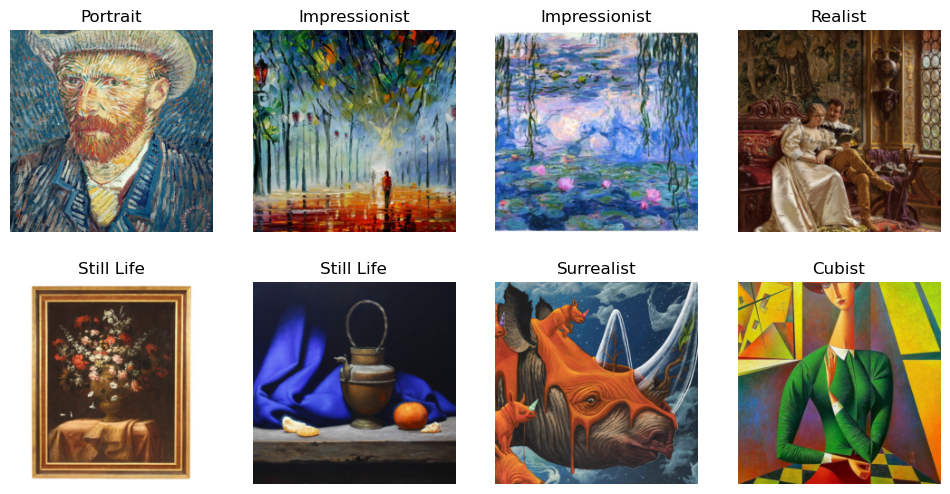

In [7]:
dataloader.train.show_batch(max_n=8, nrows=2)

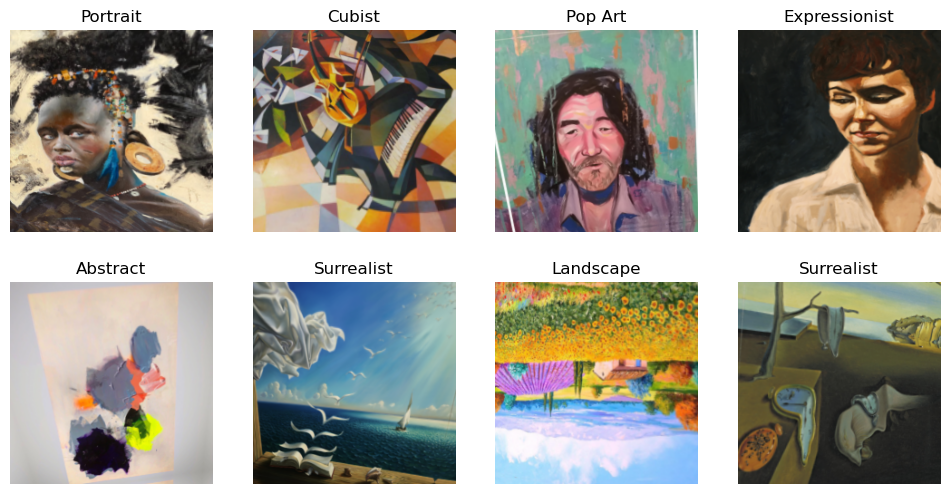

In [8]:
dblock = dblock.new(item_tfms=Resize(224, ResizeMethod.Squish), batch_tfms=aug_transforms(do_flip=True,
                                                                                         flip_vert=True,
                                                                                          max_rotate=10,
                                                                                          max_lighting=0.1,
                                                                                         )) 
dls = dblock.dataloaders(train)
dls.train.show_batch(max_n=8, nrows=2)

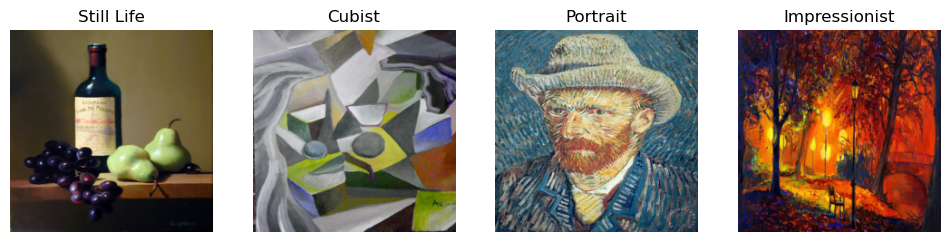

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

# Model Construction

In [10]:
model = cnn_learner(dls, densenet201, metrics=[error_rate,accuracy])

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet

In [11]:
model.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.134960,1.803133,0.557143,0.442857,01:26
1,2.259747,1.054213,0.321429,0.678571,01:30
2,1.725849,0.928841,0.271429,0.728571,01:31
3,1.356950,1.001579,0.250000,0.750000,01:30
4,1.079827,0.958500,0.264286,0.735714,01:33
5,0.887397,0.899498,0.235714,0.764286,01:32
6,0.753892,0.961104,0.257143,0.742857,01:31
7,0.620811,1.044892,0.242857,0.757143,01:31
8,0.520731,0.968888,0.221429,0.778571,01:28
9,0.435646,0.931521,0.214286,0.785714,01:32


# validation

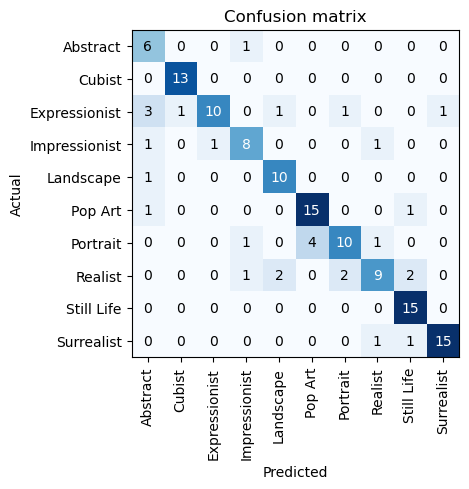

In [12]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

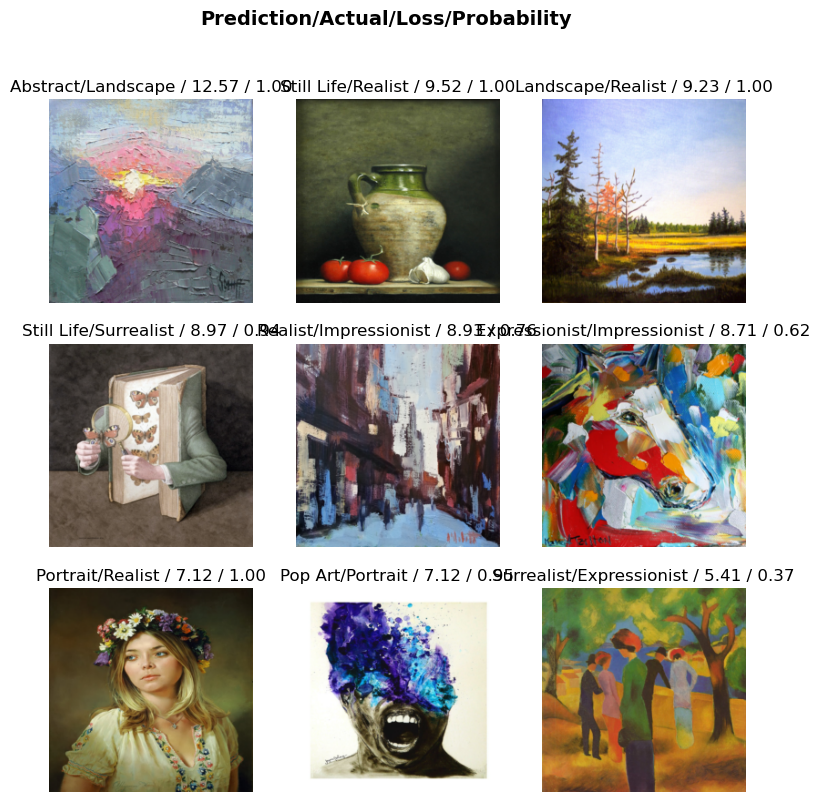

In [13]:
interp.plot_top_losses(9, nrows=3)

In [14]:
model.save('modelv2')

Path('models/modelv2.pth')